In [ ]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from operator import attrgetter

path = Path("../data")

FEATURE ENGINEERING

- add_time_features(): adds months_since_signup, months_since_new_contract, no_new_contract, months_left, permanent_contract

- add_ratios(): adds ratios of different features

- add_agg_stats(): adds means, stds, mins, maxes. As there are many possible combinations, perhaps it is better to just make a few

As an idea, extra features could be created that compare monthly features and ratios with aggregate features


In [186]:
advertisers = pd.read_parquet(path / "zrive_dim_advertiser.parquet")
df = pd.read_csv(path / "df_target.csv")

In [5]:
df.columns

Index(['advertiser_zrive_id', 'period_int', 'monthly_published_ads',
       'monthly_unique_published_ads', 'monthly_contracted_ads',
       'monthly_leads', 'monthly_visits', 'monthly_oro_ads',
       'monthly_plata_ads', 'monthly_destacados_ads', 'monthly_pepitas_ads',
       'monthly_shows', 'monthly_total_phone_views', 'monthly_total_calls',
       'monthly_total_emails', 'monthly_total_invoice', 'monthly_unique_calls',
       'monthly_unique_emails', 'monthly_unique_leads', 'monthly_avg_ad_price',
       'monthly_distinct_ads', 'has_active_contract', 'month_period', 'churn'],
      dtype='object')

In [91]:
advertisers.columns

Index(['advertiser_zrive_id', 'province_id', 'updated_at',
       'advertiser_province', 'advertiser_group_id', 'min_start_contrato_date',
       'max_start_contrato_nuevo_date', 'contrato_churn_date'],
      dtype='object')

TIME FEATURES

In [ ]:
def add_time_features(df,advertisers):
    '''
    Adds the following features to the dataset: 
    months_since_signup, months_since_new_contract, no_new_contract, months_left, permanent_contract
    '''

    df = df.merge(advertisers, on='advertiser_zrive_id', how='left')
    
    #Convert to period in months
    df['month_period'] = pd.to_datetime(df['month_period']).dt.to_period('M')
    df['min_start_contrato_date'] = pd.to_datetime(df['min_start_contrato_date'], errors='coerce').dt.to_period('M')
    df['max_start_contrato_nuevo_date'] = pd.to_datetime(df['max_start_contrato_nuevo_date'], errors='coerce').dt.to_period('M')
    df['contrato_churn_date'] = pd.to_datetime(df['contrato_churn_date'], errors='coerce').dt.to_period('M')
    
    current_date = df['month_period']
    start_date = df['min_start_contrato_date']
    new_start_date = df['max_start_contrato_nuevo_date']
    end_date = df['contrato_churn_date']

    #Compute months_since_signup
    df['months_since_signup'] = (current_date - start_date).apply(attrgetter('n'))

    #Compute months_since_new_contract. If there is no new contract, mark as a 1 in no_new_contract column
    df['months_since_new_contract'] = (current_date - new_start_date).apply(lambda x: x.n if pd.notnull(x) else None)
    df['no_new_contract'] = df['months_since_new_contract'].isna().astype(int)

    #Compute months_left. If there is no end date, mark as a 1 in permanent_contract column
    df['months_left'] = (end_date - current_date).apply(lambda x: x.n if pd.notnull(x) else None)
    df['permanent_contract'] = df['months_left'].isna().astype(int)


    df = df.drop(['period_int','month_period', 'province_id', 'updated_at',
       'advertiser_province', 'advertiser_group_id', 'min_start_contrato_date',
       'max_start_contrato_nuevo_date', 'contrato_churn_date'], axis=1)

    return df


In [ ]:
df2 = add_time_features(df,advertisers)
df2.columns

Index(['monthly_published_ads', 'monthly_unique_published_ads',
       'monthly_contracted_ads', 'monthly_leads', 'monthly_visits',
       'monthly_oro_ads', 'monthly_plata_ads', 'monthly_destacados_ads',
       'monthly_pepitas_ads', 'monthly_shows', 'monthly_total_phone_views',
       'monthly_total_calls', 'monthly_total_emails', 'monthly_total_invoice',
       'monthly_unique_calls', 'monthly_unique_emails', 'monthly_unique_leads',
       'monthly_avg_ad_price', 'monthly_distinct_ads', 'has_active_contract',
       'churn', 'months_since_signup', 'months_since_new_contract',
       'no_new_contract', 'months_left', 'permanent_contract'],
      dtype='object')

RATIOS

In [ ]:
def add_ratios(df):
    '''
    Adds the following features to the dataset: 
    published_per_contracted_ads, leads_per_visit, leads_per_ad, leads_per_premium_ad, ROI
    '''

    df['published_per_contracted_ads'] = df['monthly_published_ads'] / df['monthly_contracted_ads']
    df['leads_per_visit'] = df['monthly_leads'] / df['monthly_visits']
    df['leads_per_ad'] = df['monthly_leads'] / df['monthly_published_ads']
    df['leads_per_premium_ad'] = df['monthly_leads'] / (df['monthly_oro_ads'] + df['monthly_plata_ads'] + df['monthly_destacados_ads'] + df['monthly_pepitas_ads'])
    df['ROI'] = df['monthly_total_invoice'] / (df['monthly_avg_ad_price'] * df['monthly_contracted_ads'])

    return df

In [ ]:
df3 = add_ratios(df2)
df3.columns

AGGREGATE STATS

In [ ]:
def add_agg_stats(df, features, months = 3, agg_funcs=['mean', 'std', 'min', 'max']):
    '''
    Adds aggregate features over the last months for the features passed to the function 
    '''

    df_agg = df.copy()

    for feature in features:
        for agg_func in agg_funcs:
            col_name = f'{feature}_{months}_months_{agg_func}'
            df_agg[col_name] = (
                df_agg.groupby('advertiser_zrive_id')[feature]
                .transform(lambda x: x.rolling(window=months, min_periods=1).agg(agg_func))
            )

    
    return df_agg


In [189]:
x = df[['advertiser_zrive_id','month_period','monthly_published_ads']]
add_agg_stats(x,['monthly_published_ads']).head(20)

,advertiser_zrive_id,month_period,monthly_published_ads,monthly_published_ads_mean_3_months,monthly_published_ads_std_3_months,monthly_published_ads_min_3_months,monthly_published_ads_max_3_months
0,1,2023-01,47,47.000000,NaN,47.0,47.0
1,1,2023-02,44,45.500000,2.121320,44.0,47.0
2,2,2023-01,31,31.000000,NaN,31.0,31.0
3,2,2023-02,31,31.000000,0.000000,31.0,31.0
4,2,2023-03,47,36.333333,9.237604,31.0,47.0
5,2,2023-04,64,47.333333,16.502525,31.0,64.0
6,2,2023-05,79,63.333333,16.010413,47.0,79.0
7,2,2023-06,76,73.000000,7.937254,64.0,79.0
8,2,2023-07,71,75.333333,4.041452,71.0,79.0
9,2,2023-08,78,75.000000,3.605551,71.0,78.0


In [ ]:
df2 = add_stats()

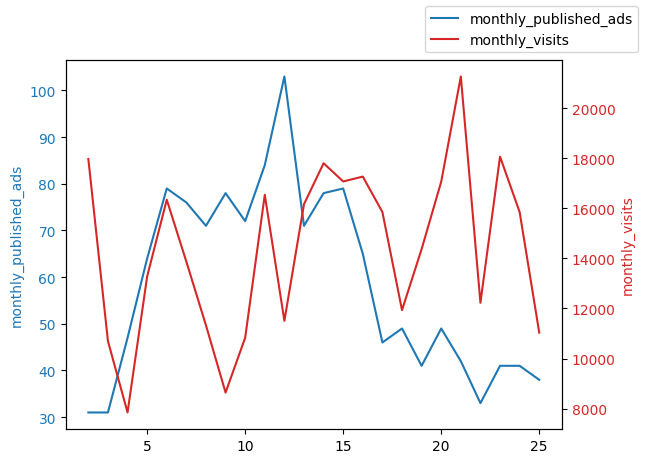

In [163]:
fig, ax1 = plt.subplots()

# First plot (left y-axis)
ax1.plot(df[df.advertiser_zrive_id==2]['monthly_published_ads'], color='tab:blue', label='monthly_published_ads')
ax1.set_ylabel('monthly_published_ads', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Second plot (right y-axis)
ax2 = ax1.twinx()  # Share the same x-axis
ax2.plot(df[df.advertiser_zrive_id==2]['monthly_visits'], color='tab:red', label='monthly_visits')
ax2.set_ylabel('monthly_visits', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.legend()

plt.show()


In [146]:
df2

,monthly_published_ads,monthly_unique_published_ads,monthly_contracted_ads,monthly_leads,monthly_visits,monthly_oro_ads,monthly_plata_ads,monthly_destacados_ads,monthly_pepitas_ads,monthly_shows,...,monthly_unique_leads,monthly_avg_ad_price,monthly_distinct_ads,has_active_contract,churn,months_since_signup,months_since_new_contract,no_new_contract,months_left,permanent_contract
0,47,47,75,18,40890.0,6,6,6,0,2051941.5,...,15,NaN,NaN,True,0,25,NaN,1,4.0,0
1,44,44,50,10,34740.0,3,3,1,0,1761028.5,...,9,NaN,NaN,True,1,26,NaN,1,3.0,0
2,31,31,150,4,17970.0,10,10,4,0,1250403.0,...,4,NaN,NaN,True,0,28,28.0,0,NaN,1
3,31,31,150,4,10695.0,10,10,4,0,1026553.5,...,4,NaN,NaN,True,0,29,29.0,0,NaN,1
4,47,47,150,6,7845.0,10,10,4,0,688947.0,...,5,NaN,NaN,True,0,30,30.0,0,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56330,8,8,10,0,3232.5,0,0,0,0,30628.5,...,0,29962.00,10.0,False,0,-7,NaN,1,NaN,1
56331,7,7,10,0,1980.0,0,0,0,0,20244.0,...,0,30990.00,8.0,False,0,-6,NaN,1,NaN,1
56332,6,6,10,0,2070.0,0,0,0,0,19299.0,...,0,33002.86,7.0,False,0,-5,NaN,1,NaN,1
56333,6,6,10,1,2055.0,0,0,0,0,20506.5,...,1,38160.00,7.0,False,0,-4,NaN,1,NaN,1


In [ ]:
df[df['months_since_signup']<-20].advertiser_zrive_id.unique()

array([2400, 2412, 6370, 6420, 6441, 6461, 6490, 6498, 6660, 6670, 6687,
       6690, 6713, 6728, 6748, 6767, 6799, 6808, 6823, 6824])

Varios usuarios están activos en la plataforma durante casi dos años antes de firmar su primer contrato

In [75]:
advertisers[advertisers['advertiser_zrive_id']==6824]

,advertiser_zrive_id,province_id,updated_at,advertiser_province,advertiser_group_id,min_start_contrato_date,max_start_contrato_nuevo_date,contrato_churn_date
259,6824,3,2025-03-17 11:53:57,Alicante,NaN,2025-03-17,None,None


In [74]:
df[df['advertiser_zrive_id']==6824]

,advertiser_zrive_id,period_int,monthly_published_ads,monthly_unique_published_ads,monthly_contracted_ads,monthly_leads,monthly_visits,monthly_oro_ads,monthly_plata_ads,monthly_destacados_ads,...,monthly_total_invoice,monthly_unique_calls,monthly_unique_emails,monthly_unique_leads,monthly_avg_ad_price,monthly_distinct_ads,has_active_contract,month_period,churn,tenure
56311,6824,202301,9,9,10,8,12315.0,0,0,0,...,0.0,1,7,8,36050.00,2.0,False,2023-01-01,0,-26
56312,6824,202302,9,9,10,12,10575.0,0,0,0,...,0.0,4,6,10,36050.00,2.0,False,2023-02-01,0,-25
56313,6824,202303,7,7,10,3,8685.0,0,0,0,...,0.0,0,3,3,36050.00,3.0,False,2023-03-01,0,-24
56314,6824,202304,7,7,10,15,15255.0,0,0,0,...,0.0,4,5,9,33281.67,3.0,False,2023-04-01,0,-23
56315,6824,202305,8,8,10,8,17685.0,0,0,0,...,0.0,2,6,8,33861.25,4.0,False,2023-05-01,0,-22
56316,6824,202306,7,7,10,5,22095.0,0,0,0,...,0.0,1,3,4,33861.25,4.0,False,2023-06-01,0,-21
56317,6824,202307,9,9,10,5,12150.0,0,0,0,...,0.0,2,3,5,33861.25,4.0,False,2023-07-01,0,-20
56318,6824,202308,9,9,10,8,13095.0,0,0,0,...,0.0,3,3,6,33861.25,4.0,False,2023-08-01,0,-19
56319,6824,202309,8,8,10,13,8692.5,0,0,0,...,0.0,4,6,10,33861.25,4.0,False,2023-09-01,0,-18
56320,6824,202310,8,8,10,3,6990.0,0,0,0,...,0.0,2,0,2,34507.50,6.0,False,2023-10-01,0,-17


In [84]:
df.loc[(df['churn']==1) & (df['has_active_contract']==False)][['advertiser_zrive_id','min_start_contrato_date','has_active_contract','month_period','churn']]

,advertiser_zrive_id,min_start_contrato_date,has_active_contract,month_period,churn
9084,801,2022-07-28,False,2023-08-01,1
25968,2500,2023-05-22,False,2023-04-01,1
45629,4743,2023-02-03,False,2023-01-01,1
46575,4910,2023-03-16,False,2023-02-01,1
47150,4998,2023-04-14,False,2023-03-01,1
48243,5174,2023-07-04,False,2023-06-01,1
48613,5240,2023-06-29,False,2023-05-01,1
50327,5468,2023-10-19,False,2023-09-01,1
55203,6308,2024-09-03,False,2024-08-01,1
